In [24]:
%matplotlib inline

import os
import imp
import random
import itertools

import numpy as np
import pandas as pd
import xarray as xr
import scipy.interpolate as interpolate

import matplotlib
import matplotlib.pyplot as plt

import climatools.io.cesm as climaio
import climatools.aerosol.aerosol as climaaerosol
import climatools.aerosol.aerosol_constants as aeroconst
import climatools.units as climaunits
import climatools.viz as climaviz

imp.reload(climaio)
imp.reload(climaaerosol)
imp.reload(aeroconst)
imp.reload(climaunits)
imp.reload(climaviz)

imp.reload(interpolate)

<module 'scipy.interpolate' from '/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/scipy/interpolate/__init__.py'>

In [5]:
dir_ozone = '/nuwa_data/data/cesm1/inputdata/atm/cam/ozone'
dir_camhist = '/scratch/lupin/cesm1/archive/f19_g16.B1850.std/atm/hist'

### Ozone interpolation

There is no ozone concentration data in CAM history, so these need to be imported from the datafile whose path is specified in the atm_in file.  

In this file, ozone concentration has dimensions (time, lat, lon, lev).
However, the lev dimension of the ozone concentration data has 26 values that are different to the 30 values of the lev dimension of CAM history.  

The ozone concentration data is linearly interpolated to the 30 values of `lev` of CAM history.

In [6]:
# original ozone concentration from data file
ds_o3 = climaaerosol.OZONE_DATASET

da_o3 = ds_o3['O3']

# get vertical pressure
ds_o3 = climaunits.hybrid2mbar(ds_o3)

In [7]:
# open one of the CAM history files to get `lev` for 30 layers
filepath_camhist = os.path.join(dir_camhist,
                                random.choice(os.listdir(dir_camhist)))
ds_camhist = xr.open_dataset(filepath_camhist, decode_cf=False)

In [8]:
# interpolate ozone concentration along `lev` 
levinterpfunc_da_o3 = climaaerosol.get_interpfunc(da_o3, dim='lev')

# get ozone concentration for CAM history's `lev` 
da_o3_levinterp = levinterpfunc_da_o3(coords=ds_camhist.coords['lev'])

# get vertical pressure
ds_camhist = climaunits.hybrid2mbar(ds_camhist)



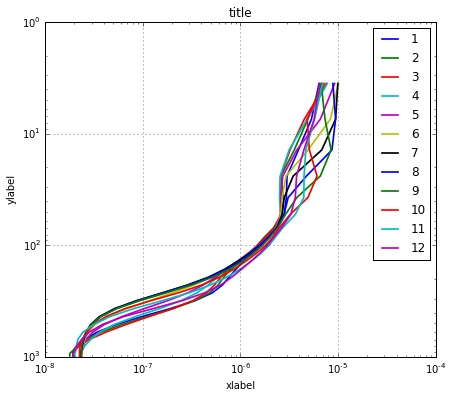

In [9]:
srss_o3 = [da_o3.isel(lat=5, lon=9, time=itime)
           .to_pandas()
           for itime, time
           in enumerate(da_o3.coords['time'])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

ax = climaviz.plot_pandas_series(srss=srss_o3, ax=ax,
                                 values_vs_index=True,
                                 logy=True, inverty=True,
                                 logx=True)

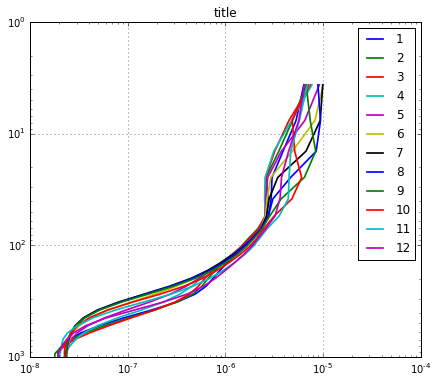

In [109]:
srss_o3_levinterp = [da_o3_levinterp.isel(lat=5, lon=9, time=itime)
                     .to_pandas() 
                     for itime, time 
                     in enumerate(da_o3_levinterp.coords['time'])]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,6))


ax = climaviz.plot_pandas_series(srss=srss_o3_levinterp, ax=axs,
                                 values_vs_index=True,
                                 logy=True, inverty=True,
                                 logx=True)

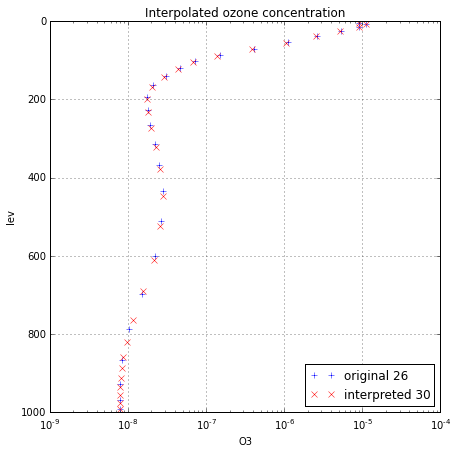

In [57]:
lat, lon, time = 40, 80, 10

srs_o3 = da_o3.isel(lat=lat, lon=lon, time=time).to_pandas()

srs_o3_interp = da_o3_levinterp.isel(lat=lat, 
                                     lon=lon, time=time).to_pandas()

srss = [srs_o3, srs_o3_interp]
names = ['original 26', 'interpreted 30']
colours = ['b', 'r']
markers = ['+', 'x']
linestyles = ['None', 'None']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax = climaviz.plot_pandas_series(srss=srss, ax=ax, 
                                 title='Interpolated ozone concentration',
                                 values_vs_index=True,
                                 names=names,
                                 colours=colours, markers=markers,
                                 linestyles=linestyles,
                                 logy=False, inverty=True, ylabel='lev',
                                 logx=True, xlabel='O3')

### CAM history `lev` to `ilev`

Certain quantities that are required as input to RRTMG-LW column model are specified at atmosphere layer boundaries (or 'levels', or 'interfaces').  These include pressure, temperature and gas concentrations.  Since these are available only for atmosphere layers in CAM history, interpolation onto layer boundaries is necessary, going from 30 `lev` values to 31 `ilev` values.

Below we try to do this by using `scipy.interpolate.interp1d`: simple linear interpolation and extrapolation for `ilev` values that are outside the range of `lev`.

Note:
Interpolation onto atmosphere layer boundaries is not required for pressure.  These are found by using using the available `hyai` and `hybi` coefficients.

#### Specific humidity `Q`

In [25]:
da_Q = ds_camhist['Q']
interpfunc_Q = climaaerosol.get_interpfunc(da_Q, dim='lev')

In [46]:
da_Q_interp = interpfunc_Q(coords=ds_camhist.coords['ilev'], 
                           name_dim='ilev')

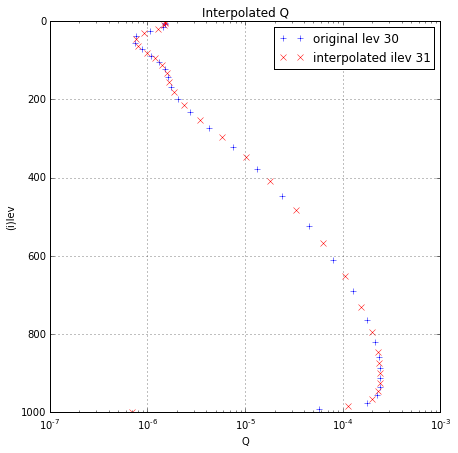

In [58]:
time, lat, lon = 0, 2, 90

srs_Q = da_Q.isel(time=time, lat=lat, lon=lon).to_pandas()
srs_Q_interp = da_Q_interp.isel(time=time, lat=lat, lon=lon).to_pandas()

srss = [srs_Q, srs_Q_interp]
names = ['original lev 30', 'interpolated ilev 31']
colours = ['b', 'r']
markers = ['+', 'x']
linestyles = ['None', 'None']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax = climaviz.plot_pandas_series(srss=srss, ax=ax, 
                                 title='Interpolated Q',
                                 values_vs_index=True,
                                 names=names,
                                 colours=colours, markers=markers,
                                 linestyles=linestyles,
                                 logy=False, inverty=True, ylabel='(i)lev',
                                 logx=True, xlabel='Q')

#### Temperature `T`

In [47]:
da_T = ds_camhist['T']
interfunc_T = climaaerosol.get_interpfunc(da=da_T, dim='lev',
                                          bounds_error=False,
                                          fill_value='extrapolate')

da_T_interp = interfunc_T(name_dim='ilev',
                          coords=ds_camhist.coords['ilev'])

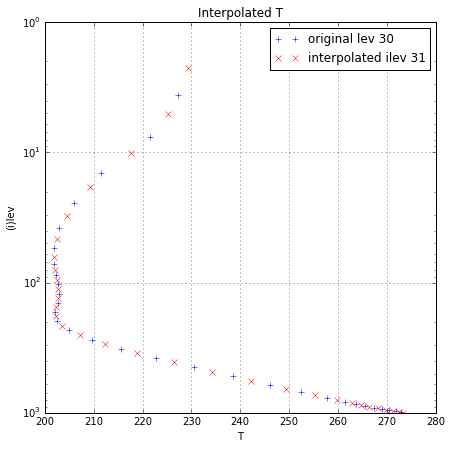

In [59]:
time, lat, lon = 0, 16, 107

srs_T = da_T.isel(time=time, lat=lat, lon=lon).to_pandas()
srs_T_interp = da_T_interp.isel(time=time, lat=lat, lon=lon).to_pandas()

srss = [srs_T, srs_T_interp]
names = ['original lev 30', 'interpolated ilev 31']
colours = ['b', 'r']
markers = ['+', 'x']
linestyles = ['None', 'None']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax = climaviz.plot_pandas_series(srss=srss, ax=ax, 
                                 title='Interpolated T',
                                 values_vs_index=True,
                                 names=names,
                                 colours=colours, markers=markers,
                                 linestyles=linestyles,
                                 logy=True, inverty=True, ylabel='(i)lev',
                                 logx=False, xlabel='T')